## Preprocesamiento de datos

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

df = pd.read_csv("Movie_classification.csv", header=0)
df = pd.get_dummies(df)
df *= 1
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Marketing_expense    506 non-null    float64
 1   Production_expense   506 non-null    float64
 2   Multiplex_coverage   506 non-null    float64
 3   Budget               506 non-null    float64
 4   Movie_length         506 non-null    float64
 5   Lead_Actor_rating    506 non-null    float64
 6   Lead_Actress_rating  506 non-null    float64
 7   Director_rating      506 non-null    float64
 8   Producer_rating      506 non-null    float64
 9   Critic_rating        506 non-null    float64
 10  Trailer_views        506 non-null    int64  
 11  Time_taken           492 non-null    float64
 12  Twitter_hastags      506 non-null    float64
 13  Avg_age_actors       506 non-null    int64  
 14  Num_multiplex        506 non-null    int64  
 15  Collection           506 non-null    int

In [4]:
# Para los datos faltantes en Time_taken usaremos KNNImputer
from sklearn.impute import KNNImputer

# Imputación usando KNN
imputer = KNNImputer(n_neighbors=10)
df_new = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Marketing_expense    506 non-null    float64
 1   Production_expense   506 non-null    float64
 2   Multiplex_coverage   506 non-null    float64
 3   Budget               506 non-null    float64
 4   Movie_length         506 non-null    float64
 5   Lead_Actor_rating    506 non-null    float64
 6   Lead_Actress_rating  506 non-null    float64
 7   Director_rating      506 non-null    float64
 8   Producer_rating      506 non-null    float64
 9   Critic_rating        506 non-null    float64
 10  Trailer_views        506 non-null    float64
 11  Time_taken           506 non-null    float64
 12  Twitter_hastags      506 non-null    float64
 13  Avg_age_actors       506 non-null    float64
 14  Num_multiplex        506 non-null    float64
 15  Collection           506 non-null    flo

<Axes: >

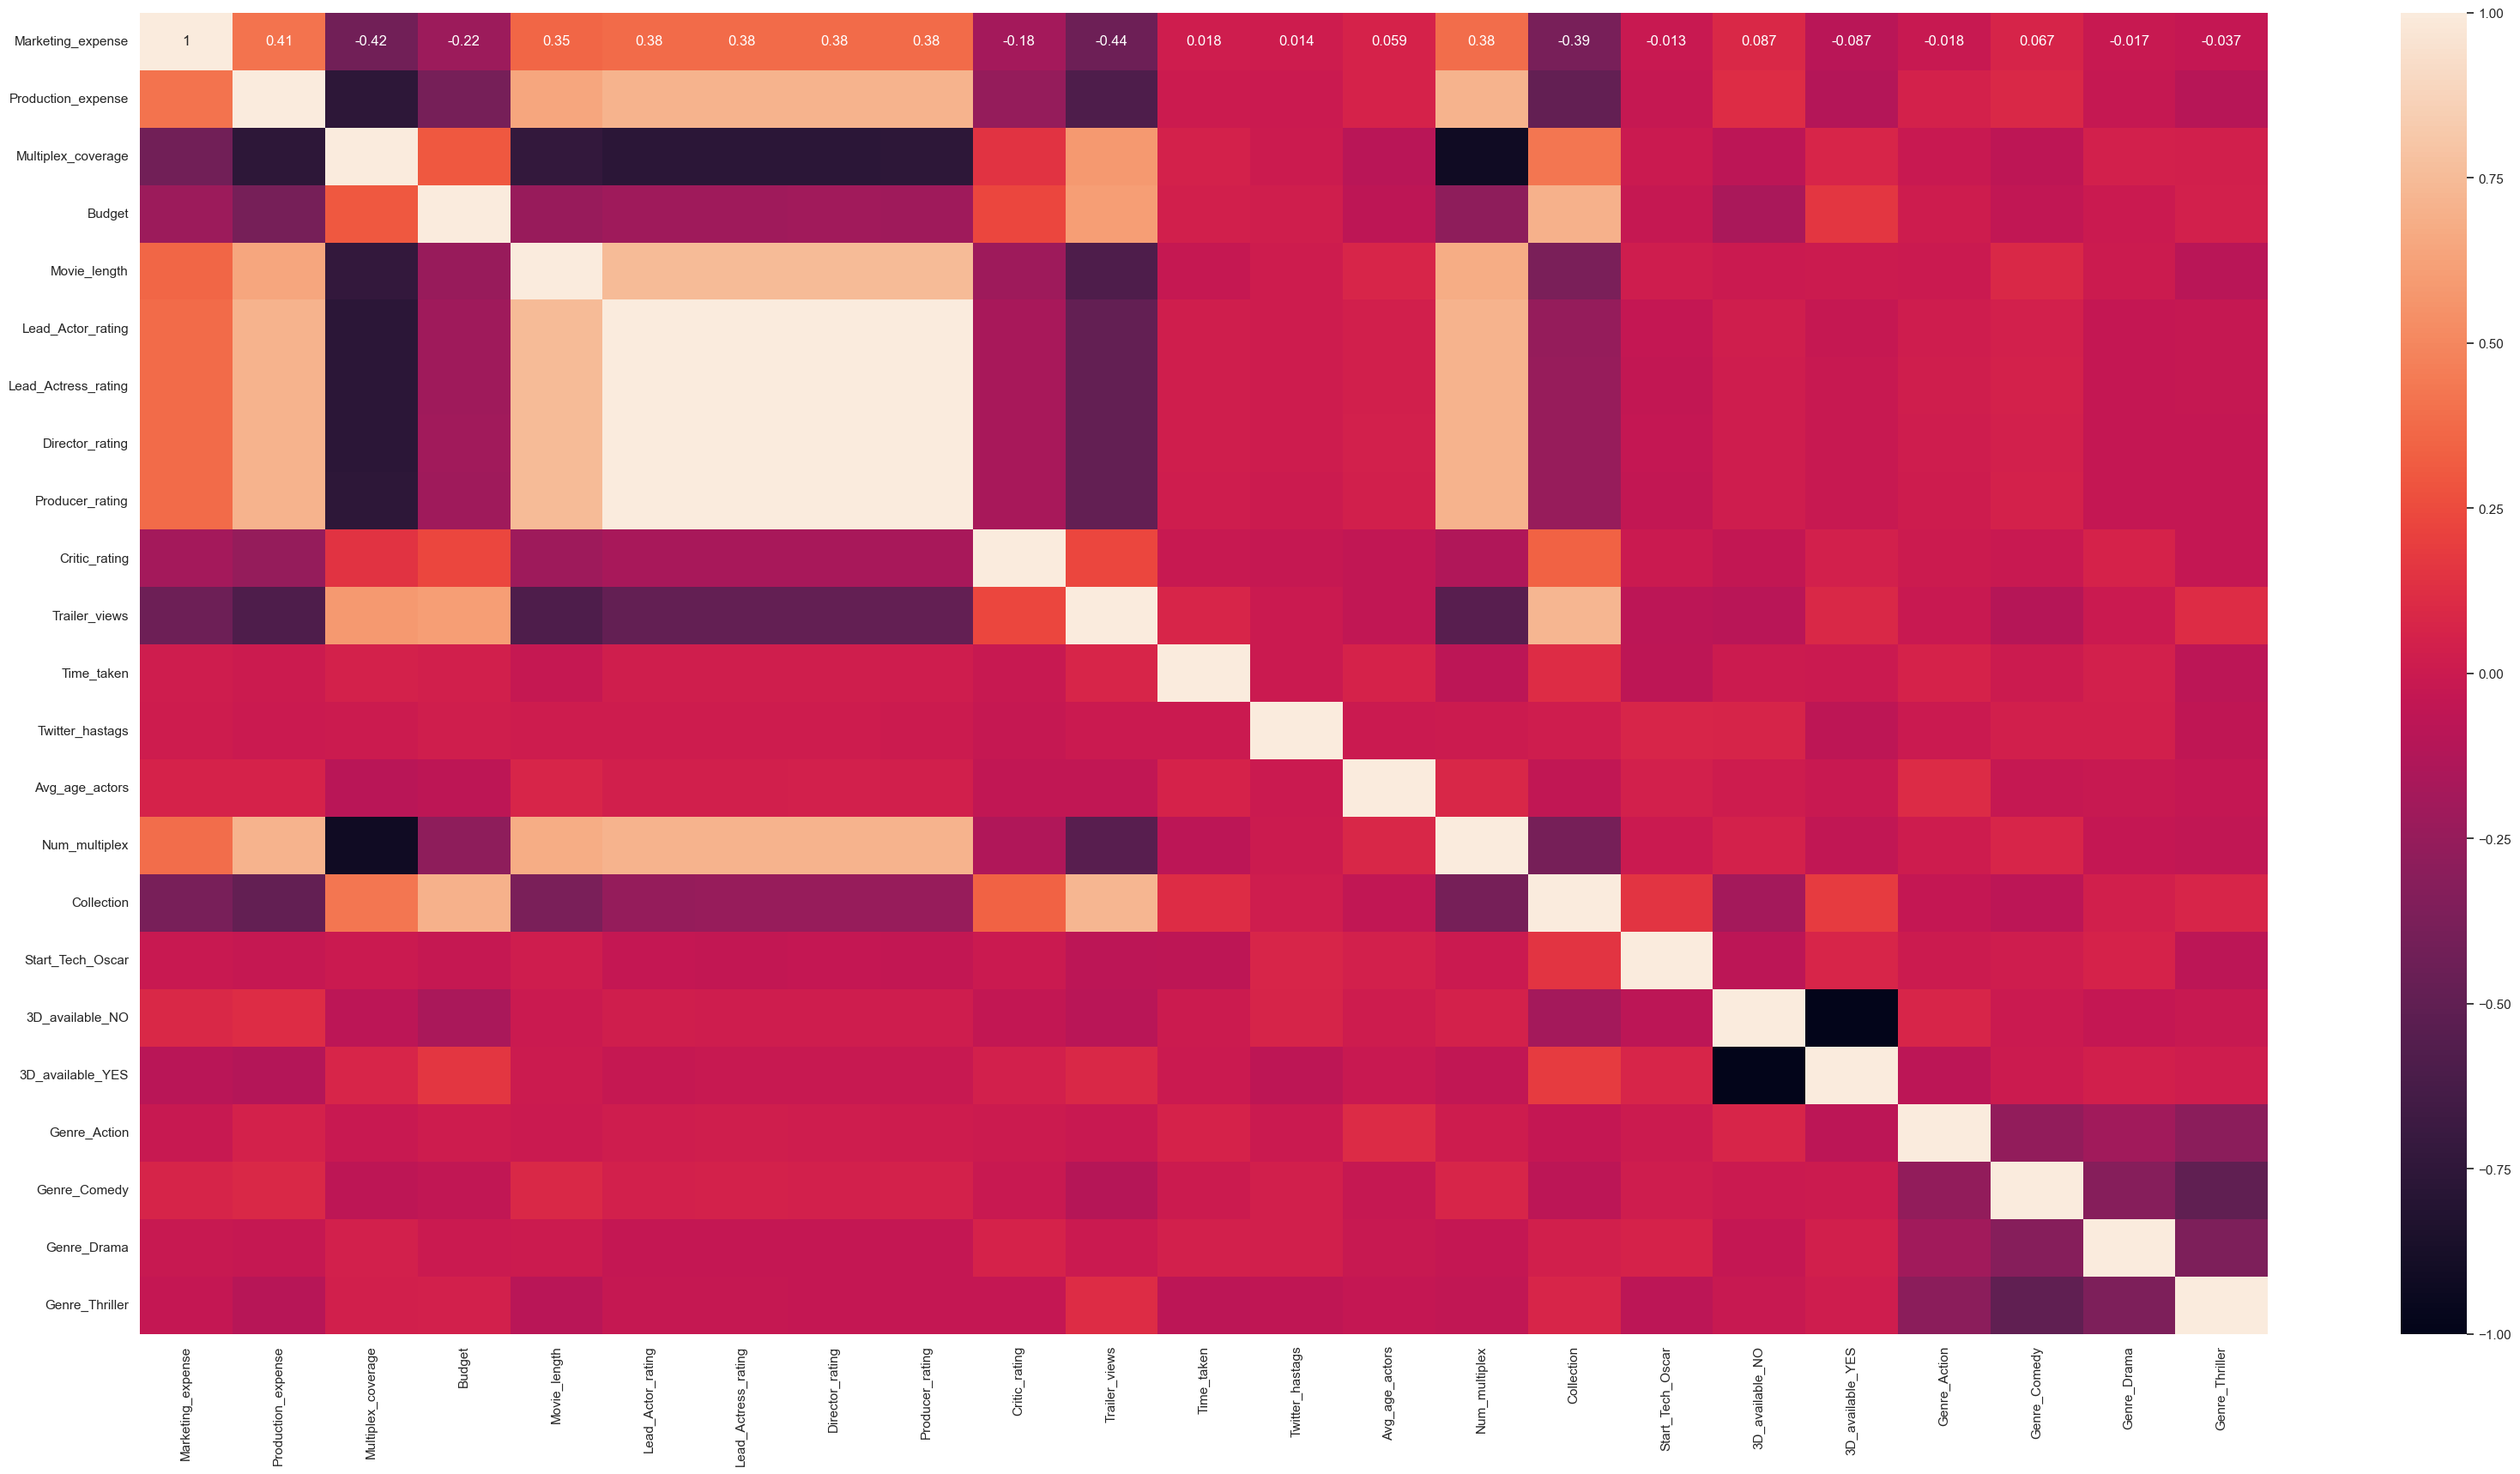

In [5]:
sns.set(style='whitegrid', context='notebook')
plt.figure(figsize=(40,20))
sns.heatmap(
    data=df_new.corr(),
    cbar=True, annot=True)

Una vez que completamos los datos faltantes con KNN Imputer con una k = 3, podemos continuar.

Parece que existe multicolinealidad.

### Multicolinealidad


In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

columnas_seleccionadas = df_new[['Lead_Actor_rating', 'Lead_Actress_rating', 'Director_rating', 'Producer_rating']]
resultado_vif = calc_vif(columnas_seleccionadas)
print(resultado_vif)

             variables           VIF
0    Lead_Actor_rating  17549.846980
1  Lead_Actress_rating  18916.417488
2      Director_rating  17939.883666
3      Producer_rating   5619.501681


Como se puede observar, existe una alta correlación entre estas 4 variables, por lo que las combinaremos para ver si es mejor opción que borrar 3 de ellas.

<Axes: >

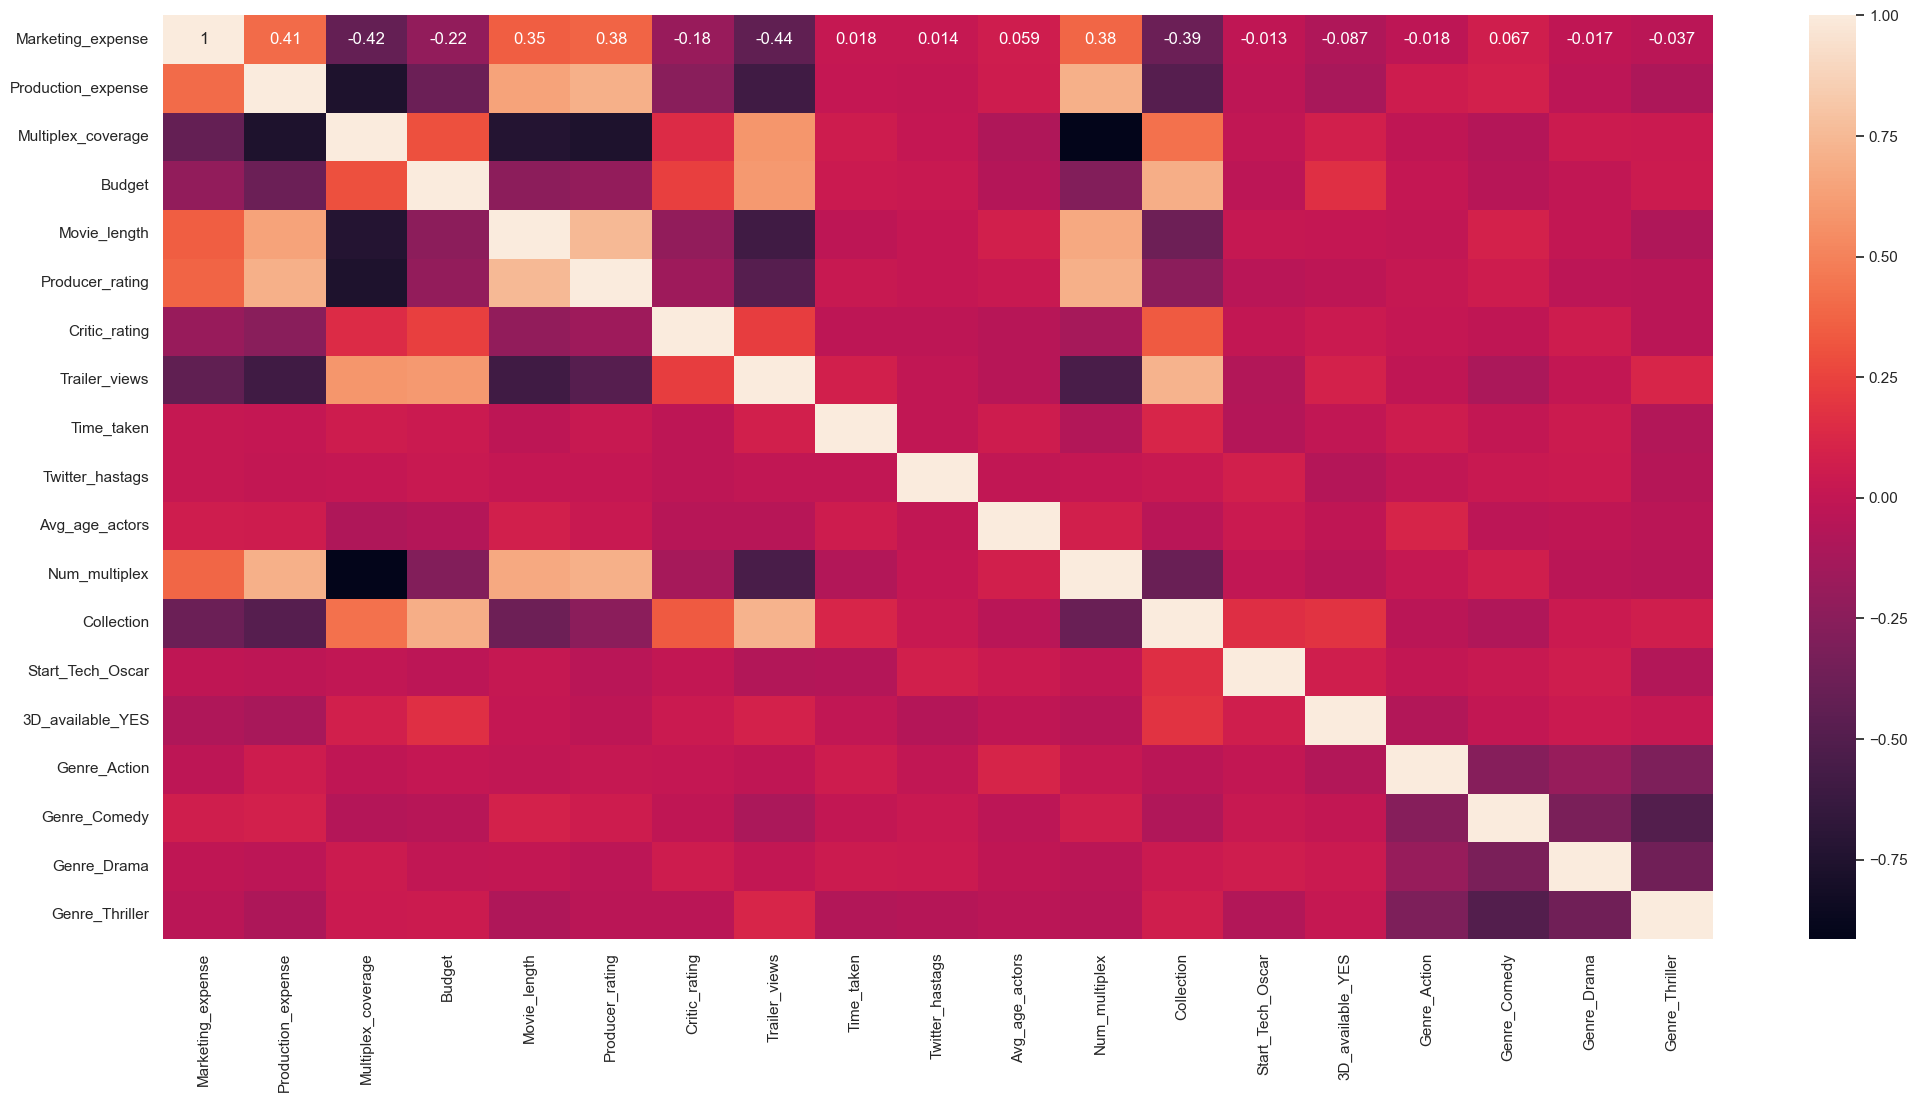

In [14]:
df_new['mean_rating'] = df_new[['Lead_Actor_rating', 'Lead_Actress_rating', 'Director_rating', 'Producer_rating']].mean(axis=1)
# La columna promemdio no tiene una mejor correlación con la variable objetivo que la columna Producer_rating por si sola

#Eliminando columnas innecesarias
del df_new['Lead_Actor_rating']
del df_new['Lead_Actress_rating']
del df_new['Director_rating']
del df_new['mean_rating']
del df_new['3D_available_NO']
sns.set(style='whitegrid', context='notebook')
plt.figure(figsize=(25,12))
sns.heatmap(
    data=df_new.corr(),
    cbar=True, annot=True)

In [16]:
#Haremos más calculos para verificar que no exista multicolinealidad en otras columnas
columnas_numericas = df_new.select_dtypes(include=['int', 'float'])
columnas_seleccionadas = df_new[['Genre_Action', 'Genre_Comedy', 'Genre_Drama', 'Genre_Thriller']]
resultado_vif = calc_vif(columnas_numericas)
print(resultado_vif)

             variables         VIF
0    Marketing_expense    1.389269
1   Production_expense    3.082922
2   Multiplex_coverage    8.879711
3               Budget    2.240597
4         Movie_length    3.034115
5      Producer_rating    3.603886
6        Critic_rating    1.218737
7        Trailer_views    3.360496
8           Time_taken    1.066056
9      Twitter_hastags    1.020429
10      Avg_age_actors    1.038889
11       Num_multiplex    6.267965
12          Collection    3.787056
13    Start_Tech_Oscar    1.212477
14    3D_available_YES    1.072630
15        Genre_Action  221.480028
16        Genre_Comedy  478.152172
17         Genre_Drama  300.550190
18      Genre_Thriller  559.232736


Parece ser que ya no existe multicolinealidad entre las variables independientes, sólo en los genéros pero no considero que afecte a la clasificación del modelo.

### Tratando outliers

In [20]:
# Pruebas de normalidad a todas las columnas
for column in df_new.columns:
    res = stats.shapiro(df_new[column])
    print(f"Prueba de Shapiro para '{column}': Estadística={res.statistic}, Valor p={res.pvalue}")

Prueba de Shapiro para 'Marketing_expense': Estadística=0.44996478021132236, Valor p=1.3285893795939306e-36
Prueba de Shapiro para 'Production_expense': Estadística=0.8997938834997925, Valor p=1.0646987056818766e-17
Prueba de Shapiro para 'Multiplex_coverage': Estadística=0.9356359807798665, Valor p=5.776225084932358e-14
Prueba de Shapiro para 'Budget': Estadística=0.9608722575483458, Valor p=2.411976537848809e-10
Prueba de Shapiro para 'Movie_length': Estadística=0.8920133099611152, Valor p=2.2307656987055587e-18
Prueba de Shapiro para 'Producer_rating': Estadística=0.9079025495924229, Valor p=5.9774466573419e-17
Prueba de Shapiro para 'Critic_rating': Estadística=0.9589814327005335, Valor p=1.1620788730486927e-10
Prueba de Shapiro para 'Trailer_views': Estadística=0.9510594376068318, Valor p=6.761193140297093e-12
Prueba de Shapiro para 'Time_taken': Estadística=0.9639616273810023, Valor p=8.356152471442573e-10
Prueba de Shapiro para 'Twitter_hastags': Estadística=0.2334974815618467, 

In [22]:
percentiles_99 = df_new.drop(columns=['Start_Tech_Oscar']).quantile(0.99)

# Iterar sobre cada columna (excepto la columna objetivo)
for column in percentiles_99.index:
    outliers = df_new[df_new[column] > percentiles_99[column]]
    df_new.loc[df_new[column] > percentiles_99[column], column] = percentiles_99[column]

Outliers detectados y atenuados en:

    Marketing_expense
    Budget
    Trailer_views
    Twitter_hastags

In [25]:
def diagmostic_grafic(df, variable):
  plt.figure(figsize=(15,6))
  plt.subplot(1,2,1)
  plt.title(variable)
  df[variable].hist(bins=30, edgecolor='black')
  plt.subplot(1,2,2)
  stats.probplot(df[variable], dist='norm', plot=plt)
  plt.title('Gráfico Q-Q')
  plt.show()

from scipy import stats

for column in df_new.columns:
    res = stats.shapiro(df_new[column])
    print(f"Prueba de Shapiro para '{column}': Estadística={res.statistic}, Valor p={res.pvalue}")

Prueba de Shapiro para 'Marketing_expense': Estadística=0.5416463058146597, Valor p=3.113170779414536e-34
Prueba de Shapiro para 'Production_expense': Estadística=0.8968266394562212, Valor p=5.807571894130839e-18
Prueba de Shapiro para 'Multiplex_coverage': Estadística=0.9338037040581634, Valor p=3.461349440844266e-14
Prueba de Shapiro para 'Budget': Estadística=0.9630778257200029, Valor p=5.817933547835184e-10
Prueba de Shapiro para 'Movie_length': Estadística=0.8920133099611152, Valor p=2.2307656987055587e-18
Prueba de Shapiro para 'Producer_rating': Estadística=0.9061289771458023, Valor p=4.0614733029127325e-17
Prueba de Shapiro para 'Critic_rating': Estadística=0.9589273051321907, Valor p=1.1384009223757704e-10
Prueba de Shapiro para 'Trailer_views': Estadística=0.9497928172245105, Valor p=4.414987487675748e-12
Prueba de Shapiro para 'Time_taken': Estadística=0.9620785629088703, Valor p=3.888588711967658e-10
Prueba de Shapiro para 'Twitter_hastags': Estadística=0.9257134160144999, 

Sólo aplicaré una transformación a Marketing_expense para normalizar un poco los datos.

Prueba de shapiro:  0.7644120808562066


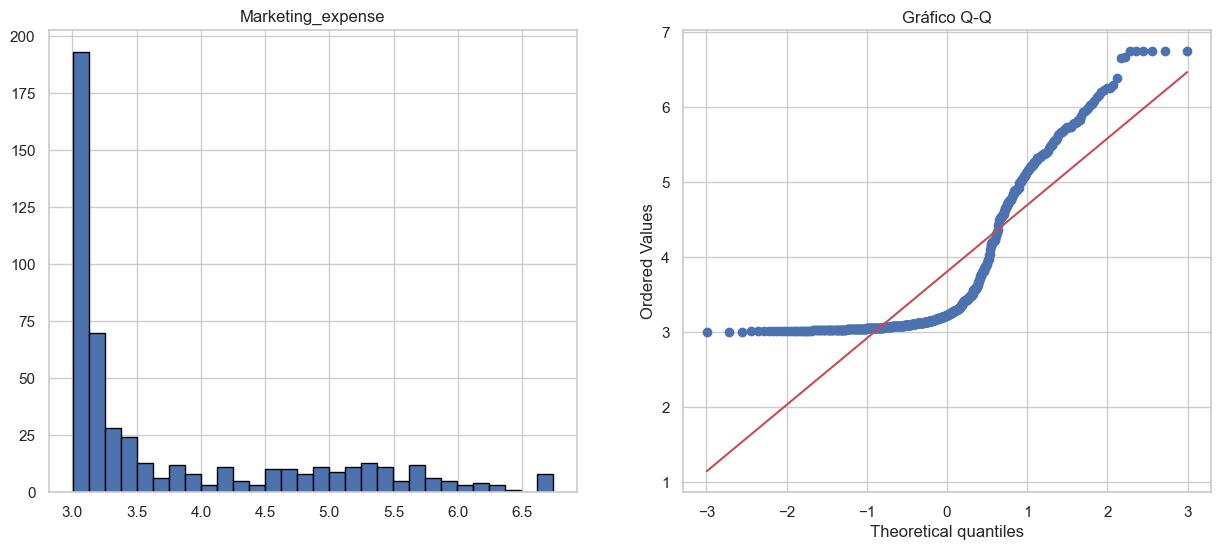

In [28]:
df_new['Marketing_expense'] = np.log(df_new['Marketing_expense'])
from scipy import stats #para realizar la prueba de normalidad shapiro
res = stats.shapiro(df_new['Marketing_expense'])
print("Prueba de shapiro: ",res.statistic)
diagmostic_grafic(df_new, 'Marketing_expense')

## Visualización de los datos

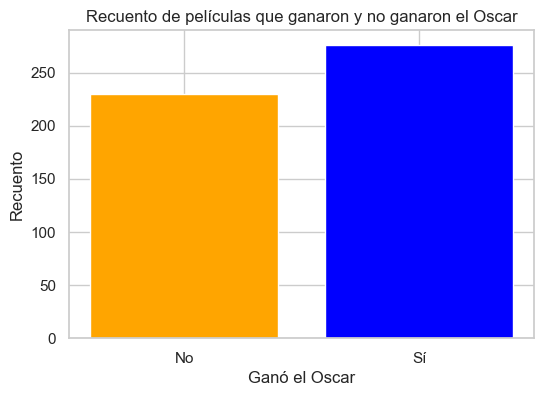

In [69]:
# Contar cuántas películas ganaron y cuántas no
win_counts = df_new['Start_Tech_Oscar'].value_counts()

# Graficar el histograma
plt.figure(figsize=(6, 4))
plt.bar(win_counts.index, win_counts.values, color=['blue', 'orange'])
plt.title('Recuento de películas que ganaron y no ganaron el Oscar')
plt.xlabel('Ganó el Oscar')
plt.ylabel('Recuento')
plt.xticks([0, 1], ['No', 'Sí'])
plt.show()

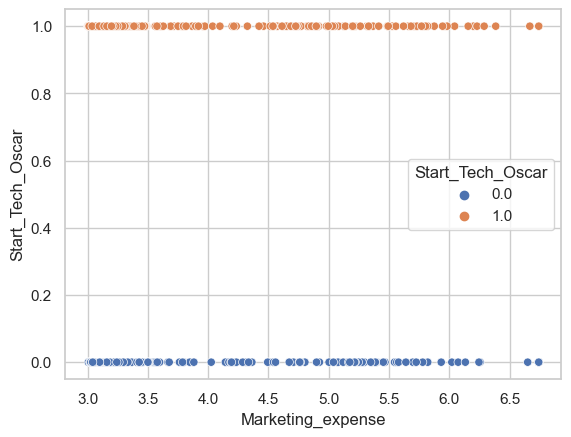

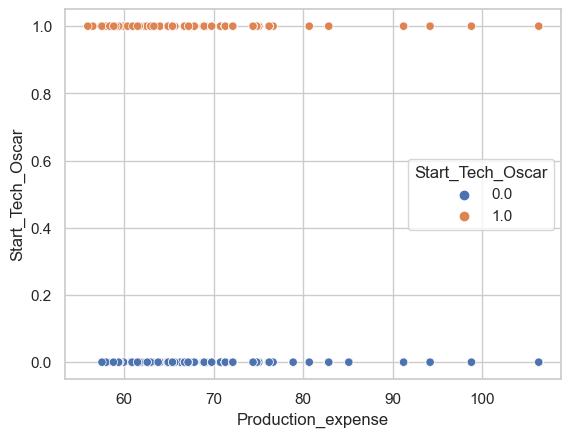

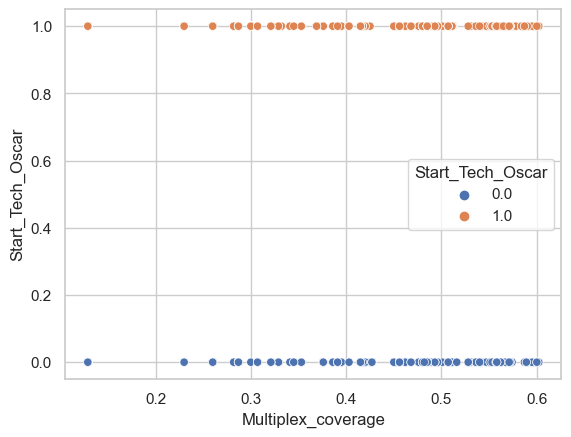

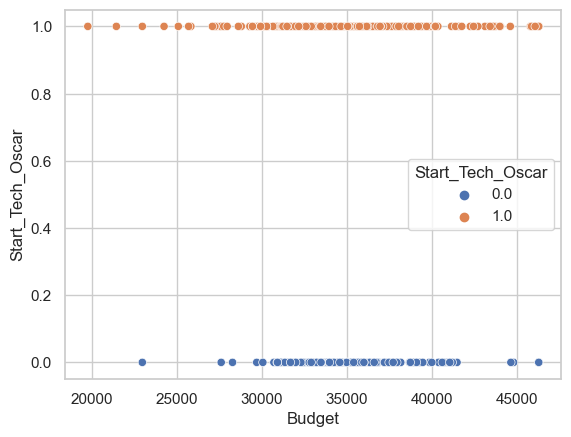

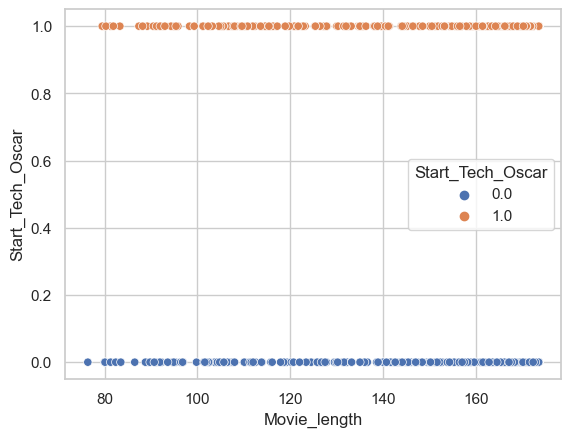

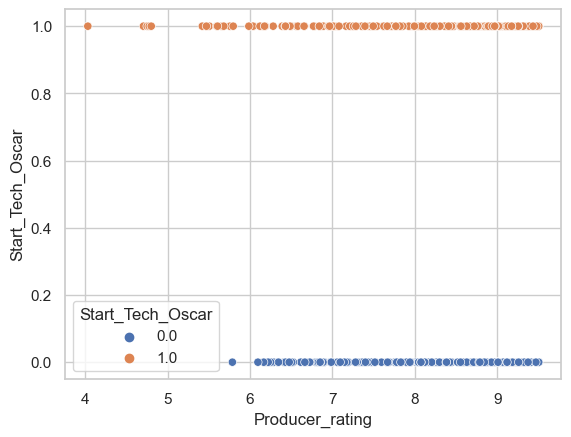

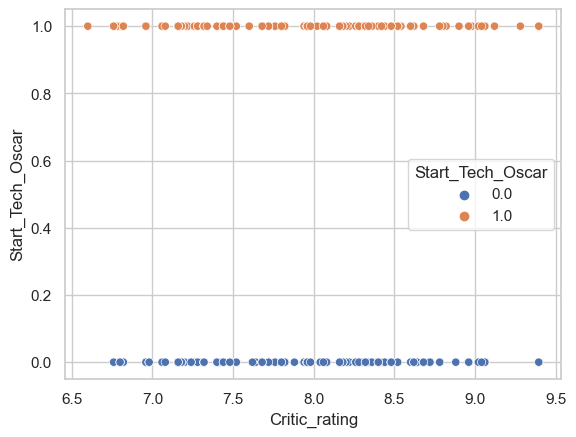

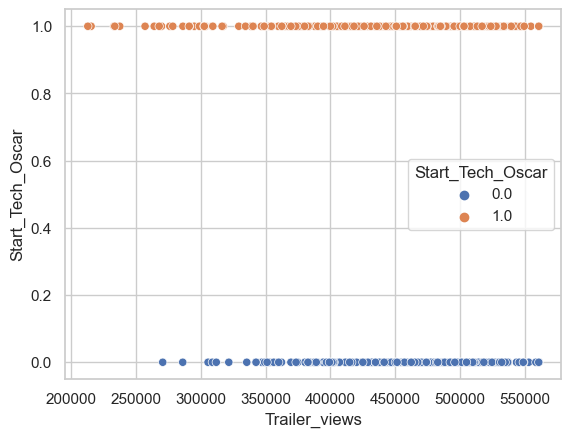

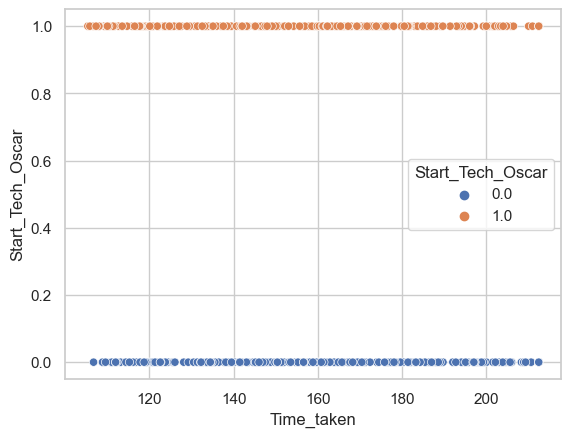

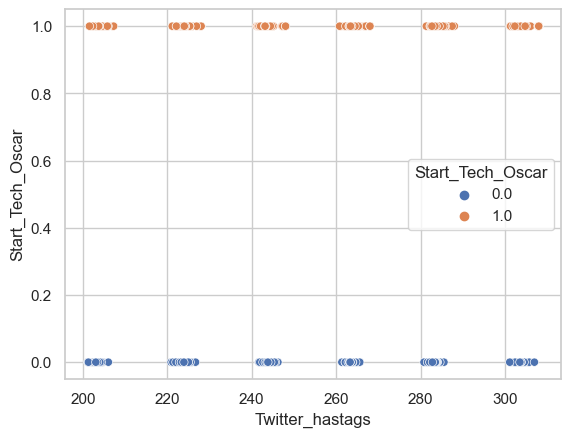

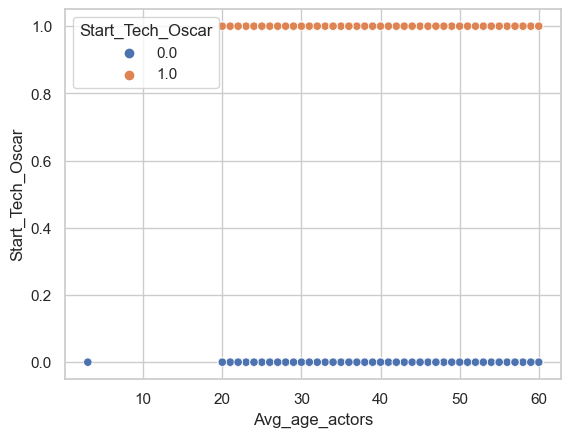

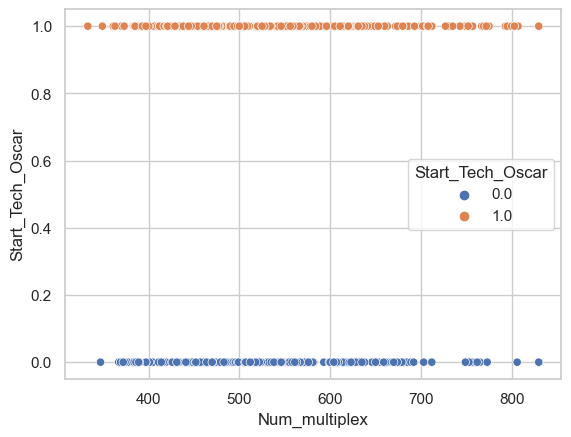

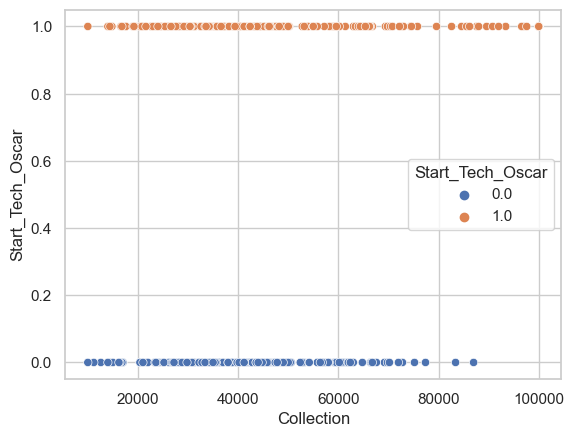

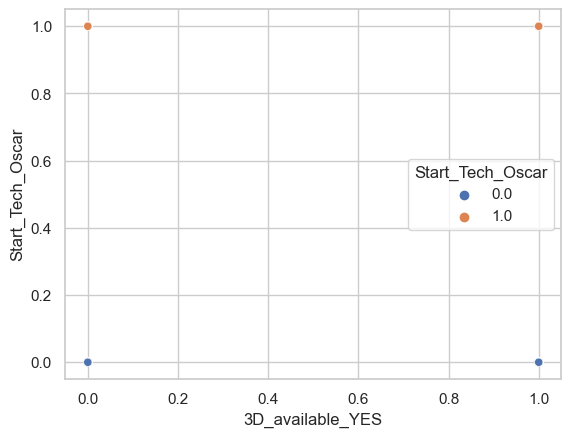

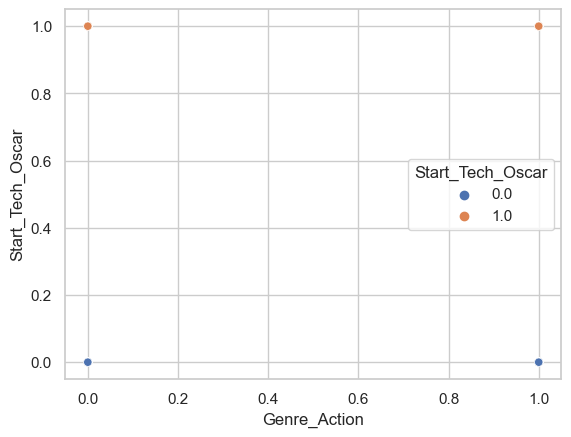

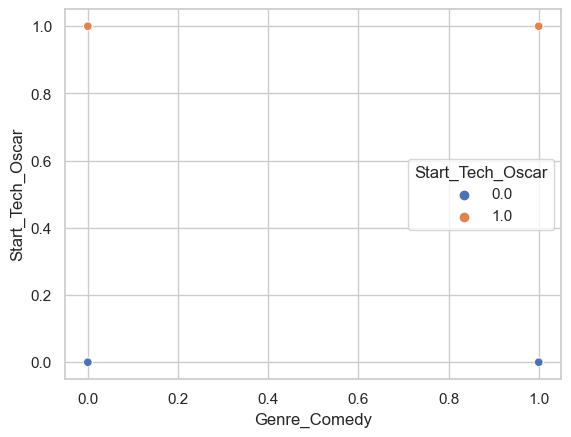

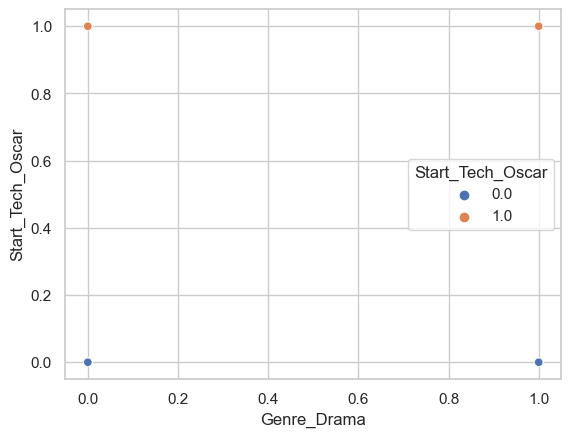

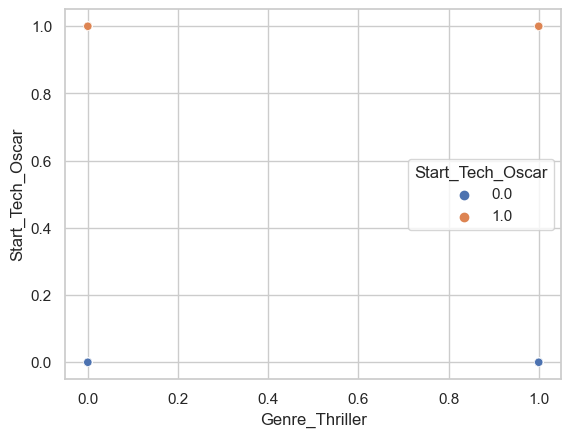

In [71]:
cols = df_new.columns.drop('Start_Tech_Oscar')  # Eliminar la variable objetivo de la lista de columnas
for col in cols:
    plt.figure()  # Crear una nueva figura para cada gráfico
    sns.scatterplot(x=col, y='Start_Tech_Oscar', hue='Start_Tech_Oscar', data=df_new)
plt.show()

## Selección de características

Para la selección de características se implementará el método wrapper usando como modelo de prueba los 4 que usaré.

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.feature_selection import SequentialFeatureSelector

# Partición del conjunto de datos
x_train_val, x_test, y_train_val, y_test = train_test_split(df_new.drop(['Start_Tech_Oscar'], axis=1), df_new['Start_Tech_Oscar'], test_size=0.2, random_state=0)

# Escalado de los datos
scaler = StandardScaler().fit(x_train_val)
X_train_val_scaled = scaler.transform(x_train_val)

# Creación de los clasificadores
classifiers = {
    "KNN": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier()
}

# Búsqueda de las mejores características para cada clasificador
selected_features = {}
for name, clf in classifiers.items():
    selector = SequentialFeatureSelector(clf, scoring='f1', n_jobs=-1, n_features_to_select='auto')
    selector.fit(X_train_val_scaled, y_train_val)
    selected_indices = selector.get_support(indices=True)
    selected_feature_names = df_new.drop(['Start_Tech_Oscar'], axis=1).columns[selected_indices]
    selected_features[name] = selected_feature_names
    print("Características seleccionadas para {}: {}".format(name, selected_feature_names))

Características seleccionadas para KNN: Index(['Marketing_expense', 'Budget', 'Movie_length', 'Trailer_views',
       'Time_taken', 'Twitter_hastags', '3D_available_YES', 'Genre_Action',
       'Genre_Thriller'],
      dtype='object')
Características seleccionadas para Logistic Regression: Index(['Marketing_expense', 'Budget', 'Movie_length', 'Time_taken',
       'Avg_age_actors', 'Num_multiplex', 'Collection', '3D_available_YES',
       'Genre_Comedy'],
      dtype='object')
Características seleccionadas para SVM: Index(['Production_expense', 'Multiplex_coverage', 'Movie_length',
       'Producer_rating', 'Critic_rating', 'Twitter_hastags', 'Num_multiplex',
       '3D_available_YES', 'Genre_Action'],
      dtype='object')
Características seleccionadas para Random Forest: Index(['Marketing_expense', 'Production_expense', 'Critic_rating',
       'Num_multiplex', '3D_available_YES', 'Genre_Action', 'Genre_Comedy',
       'Genre_Drama', 'Genre_Thriller'],
      dtype='object')


## Búsqueda aleatoria para selección de hiperparámetros e implementación de modelos

### KNN

Con la selección de características:
Promedio F1 en la validación cruzada: 0.6040539549438326
Mejores parámetros encontrados: {'metric': 'euclidean', 'n_neighbors': 5}
F1-score promedio utilizando k-Fold Cross Validation: 0.5892063492063493


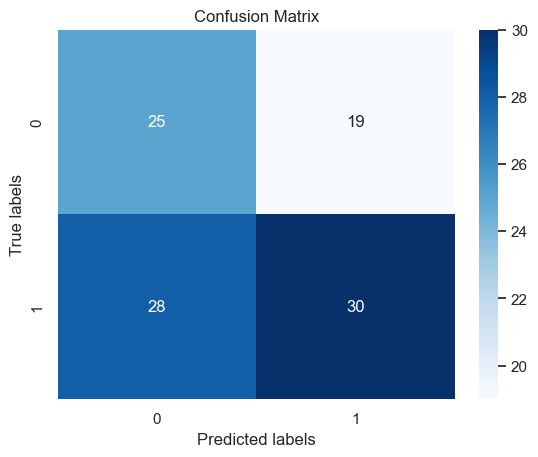

Con todas las características:
Promedio F1 en la validación cruzada: 0.5954650066863062
Mejores parámetros encontrados: {'metric': 'manhattan', 'n_neighbors': 9}
F1-score promedio utilizando k-Fold Cross Validation: 0.633989343989344


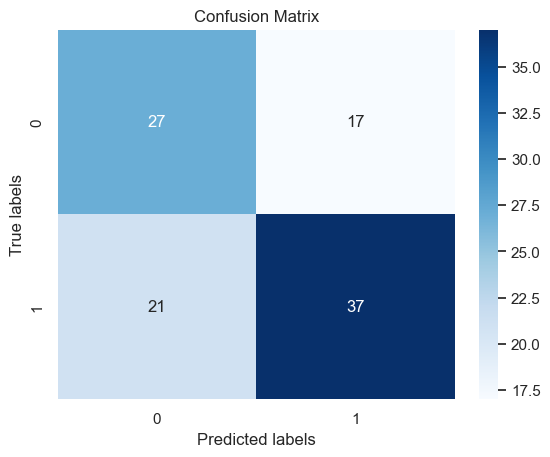

In [145]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, f1_score

# Seleccionar las características
selected_features = ['Marketing_expense', 'Budget', 'Movie_length', 'Trailer_views', 'Time_taken', 'Twitter_hastags', '3D_available_YES', 'Genre_Action', 'Genre_Thriller']
X_selected = df_new[selected_features]

# Partición del conjunto de datos en entrenamiento, validación y prueba
x_train, x_test, y_train, y_test = train_test_split(X_selected, df_new['Start_Tech_Oscar'], test_size=0.2, random_state=0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=0) # Dividir en entrenamiento y validación

# Escalado de los datos
scaler = StandardScaler().fit(x_train)
X_train_scaled = scaler.transform(x_train)
X_val_scaled = scaler.transform(x_val)
X_test_scaled = scaler.transform(x_test)

# Definir la cuadrícula de parámetros para la búsqueda aleatoria
param_grid = {
    'n_neighbors': randint(1, 21),  # Número de vecinos
    'metric': ['euclidean', 'manhattan']  # Métrica de distancia
}

knn_classifier = KNeighborsClassifier()
random_search = RandomizedSearchCV(knn_classifier, param_distributions=param_grid, n_iter=100, scoring='f1', n_jobs=-1, cv=5, random_state=0)

# Realizar la validación cruzada en el conjunto de entrenamiento y validación
cv_scores = cross_val_score(random_search, np.vstack((X_train_scaled, X_val_scaled)), np.hstack((y_train, y_val)), scoring='f1', cv=5)

# Imprimir el promedio F1 en la validación cruzada
print("Con la selección de características:")
print("Promedio F1 en la validación cruzada:", np.mean(cv_scores))

# Entrenar el modelo con los mejores parámetros encontrados
best_knn_classifier = random_search.fit(np.vstack((X_train_scaled, X_val_scaled)), np.hstack((y_train, y_val)))

# Obtener los mejores parámetros encontrados
best_params = best_knn_classifier.best_params_
print("Mejores parámetros encontrados:", best_params)

# Predicciones en el conjunto de prueba
y_pred = best_knn_classifier.predict(X_test_scaled)

# Calcular F1-score utilizando k-Fold Cross Validation
f1_scores = cross_val_score(best_knn_classifier, X_test_scaled, y_test, scoring='f1', cv=10)
print("F1-score promedio utilizando k-Fold Cross Validation:", np.mean(f1_scores))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

##########################################################################################################################

# Seleccionar todas las características disponibles en el dataset
X_all_features = df_new.drop('Start_Tech_Oscar', axis=1)
y = df_new['Start_Tech_Oscar']

# Partición del conjunto de datos en entrenamiento, validación y prueba
x_train, x_test, y_train, y_test = train_test_split(X_all_features, y, test_size=0.2, random_state=0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=0) # Dividir en entrenamiento y validación

# Escalado de los datos
scaler = StandardScaler().fit(x_train)
X_train_scaled = scaler.transform(x_train)
X_val_scaled = scaler.transform(x_val)
X_test_scaled = scaler.transform(x_test)

# Definir la cuadrícula de parámetros para la búsqueda aleatoria
param_grid = {
    'n_neighbors': randint(1, 21),  # Número de vecinos
    'metric': ['euclidean', 'manhattan']  # Métrica de distancia
}

knn_classifier = KNeighborsClassifier()
random_search = RandomizedSearchCV(knn_classifier, param_distributions=param_grid, n_iter=100, scoring='f1', n_jobs=-1, cv=5, random_state=0)

# Realizar la validación cruzada en el conjunto de entrenamiento y validación
cv_scores = cross_val_score(random_search, np.vstack((X_train_scaled, X_val_scaled)), np.hstack((y_train, y_val)), scoring='f1', cv=5)

# Imprimir el promedio F1 en la validación cruzada
print("Con todas las características:")
print("Promedio F1 en la validación cruzada:", np.mean(cv_scores))

# Entrenar el modelo con los mejores parámetros encontrados
best_knn_classifier = random_search.fit(np.vstack((X_train_scaled, X_val_scaled)), np.hstack((y_train, y_val)))

# Obtener los mejores parámetros encontrados
best_params = best_knn_classifier.best_params_
print("Mejores parámetros encontrados:", best_params)

# Predicciones en el conjunto de prueba
y_pred = best_knn_classifier.predict(X_test_scaled)

# Calcular F1-score utilizando k-Fold Cross Validation
f1_scores = cross_val_score(best_knn_classifier, X_test_scaled, y_test, scoring='f1', cv=10)
print("F1-score promedio utilizando k-Fold Cross Validation:", np.mean(f1_scores))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Regresión logística

Con la selección de características:
Promedio F1 en la validación cruzada: 0.6836662137971983
Mejores parámetros encontrados: {'C': 0.010553568650085712, 'max_iter': 122, 'penalty': 'l2', 'solver': 'saga'}
F1-score promedio utilizando k-Fold Cross Validation: 0.7078431372549019


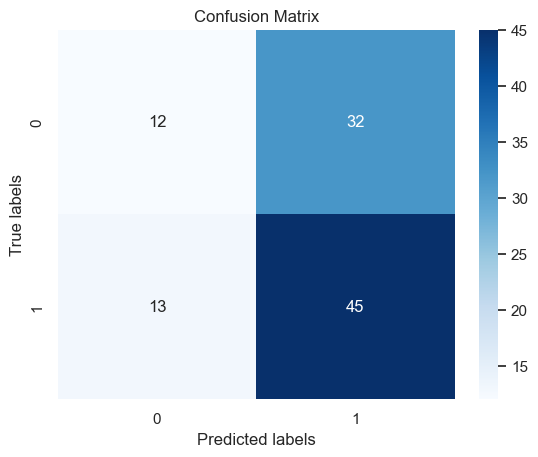

Con todas las características:
Promedio F1 en la validación cruzada: 0.646039240976868
Mejores parámetros encontrados: {'C': 0.010553568650085712, 'max_iter': 122, 'penalty': 'l2', 'solver': 'saga'}
F1-score promedio utilizando k-Fold Cross Validation: 0.6527527374586197


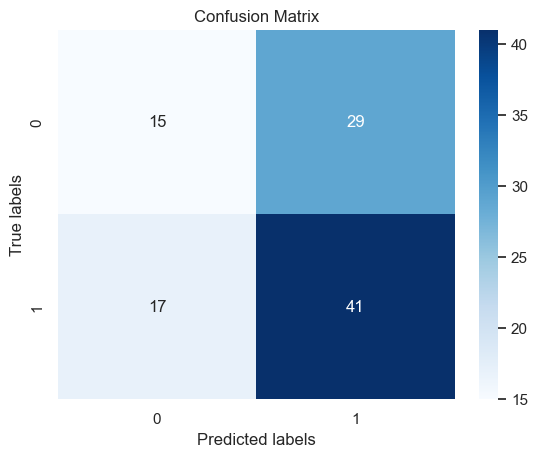

In [154]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score

# Seleccionar las características
selected_features = ['Marketing_expense', 'Budget', 'Movie_length', 'Time_taken','Avg_age_actors', 'Num_multiplex', 'Collection', '3D_available_YES','Genre_Comedy']
X_selected = df_new[selected_features]

# Partición del conjunto de datos en entrenamiento, validación y prueba
x_train, x_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=0) # Dividir en entrenamiento y validación

# Escalado de los datos
scaler = StandardScaler().fit(x_train)
X_train_scaled = scaler.transform(x_train)
X_val_scaled = scaler.transform(x_val)
X_test_scaled = scaler.transform(x_test)

# Definir la cuadrícula de parámetros para la búsqueda aleatoria
param_grid = {
    'penalty': ['l1', 'l2'],  # Tipo de regularización
    'C': uniform(0.01, 10),    # Parámetro de regularización
    'solver': ['liblinear', 'saga'],  # Algoritmo de optimización
    'max_iter': randint(50, 200)  # Número máximo de iteraciones
}

logistic_regression = LogisticRegression()
random_search = RandomizedSearchCV(logistic_regression, param_distributions=param_grid, n_iter=100, scoring='f1', n_jobs=-1, cv=5, random_state=0)

# Realizar la validación cruzada en el conjunto de entrenamiento y validación
cv_scores = cross_val_score(random_search, np.vstack((X_train_scaled, X_val_scaled)), np.hstack((y_train, y_val)), scoring='f1', cv=5)

# Imprimir el promedio F1 en la validación cruzada
print("Con la selección de características:")
print("Promedio F1 en la validación cruzada:", np.mean(cv_scores))

# Entrenar el modelo con los mejores parámetros encontrados
best_logistic_regression = random_search.fit(np.vstack((X_train_scaled, X_val_scaled)), np.hstack((y_train, y_val)))

# Obtener los mejores parámetros encontrados
best_params = best_logistic_regression.best_params_
print("Mejores parámetros encontrados:", best_params)

# Predicciones en el conjunto de prueba
y_pred = best_logistic_regression.predict(X_test_scaled)

# Calcular F1-score utilizando k-Fold Cross Validation
f1_scores = cross_val_score(best_logistic_regression, X_test_scaled, y_test, scoring='f1', cv=10)
print("F1-score promedio utilizando k-Fold Cross Validation:", np.mean(f1_scores))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

##########################################################################################################################

# Seleccionar las características
X_selected = df_new.drop('Start_Tech_Oscar', axis=1)
y = df_new['Start_Tech_Oscar']

# Partición del conjunto de datos en entrenamiento, validación y prueba
x_train, x_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=0) # Dividir en entrenamiento y validación

# Escalado de los datos
scaler = StandardScaler().fit(x_train)
X_train_scaled = scaler.transform(x_train)
X_val_scaled = scaler.transform(x_val)
X_test_scaled = scaler.transform(x_test)

# Definir la cuadrícula de parámetros para la búsqueda aleatoria
param_grid = {
    'penalty': ['l1', 'l2'],  # Tipo de regularización
    'C': uniform(0.01, 10),    # Parámetro de regularización
    'solver': ['liblinear', 'saga'],  # Algoritmo de optimización
    'max_iter': randint(50, 200)  # Número máximo de iteraciones
}

logistic_regression = LogisticRegression()
random_search = RandomizedSearchCV(logistic_regression, param_distributions=param_grid, n_iter=100, scoring='f1', n_jobs=-1, cv=5, random_state=0)

# Realizar la validación cruzada en el conjunto de entrenamiento y validación
cv_scores = cross_val_score(random_search, np.vstack((X_train_scaled, X_val_scaled)), np.hstack((y_train, y_val)), scoring='f1', cv=5)

# Imprimir el promedio F1 en la validación cruzada
print("Con todas las características:")
print("Promedio F1 en la validación cruzada:", np.mean(cv_scores))

# Entrenar el modelo con los mejores parámetros encontrados
best_logistic_regression = random_search.fit(np.vstack((X_train_scaled, X_val_scaled)), np.hstack((y_train, y_val)))

# Obtener los mejores parámetros encontrados
best_params = best_logistic_regression.best_params_
print("Mejores parámetros encontrados:", best_params)

# Predicciones en el conjunto de prueba
y_pred = best_logistic_regression.predict(X_test_scaled)

# Calcular F1-score utilizando k-Fold Cross Validation
f1_scores = cross_val_score(best_logistic_regression, X_test_scaled, y_test, scoring='f1', cv=10)
print("F1-score promedio utilizando k-Fold Cross Validation:", np.mean(f1_scores))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### SVM (Máquinas de soporte vectorial)

Con la selección de características:
Promedio F1 en la validación cruzada: 0.6699212908856889
Mejores parámetros encontrados: {'C': 0.23854917250062058, 'coef0': -0.22941925149722375, 'degree': 5, 'gamma': 'scale', 'kernel': 'rbf'}
F1-score promedio utilizando k-Fold Cross Validation: 0.7245098039215685


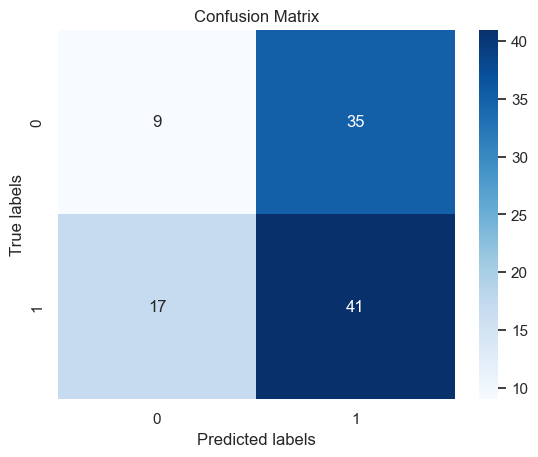

Con todas las características:
Promedio F1 en la validación cruzada: 0.6963716864661817
Mejores parámetros encontrados: {'C': 0.23854917250062058, 'coef0': -0.22941925149722375, 'degree': 5, 'gamma': 'scale', 'kernel': 'rbf'}
F1-score promedio utilizando k-Fold Cross Validation: 0.7245098039215685


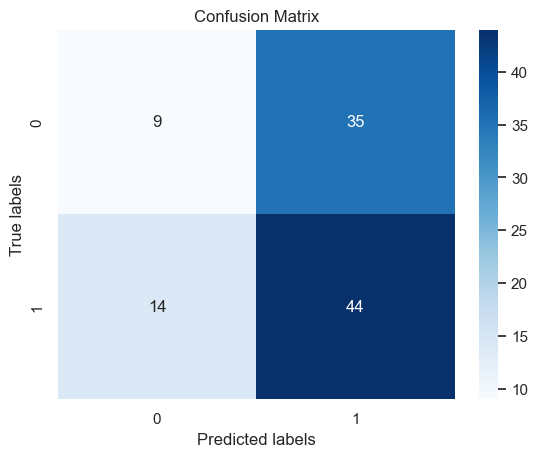

In [163]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score

# Seleccionar las características
selected_features = ['Marketing_expense', 'Budget', 'Movie_length', 'Time_taken','Avg_age_actors', 'Num_multiplex', 'Collection', '3D_available_YES','Genre_Comedy']
X_selected = df_new[selected_features]

# Partición del conjunto de datos en entrenamiento, validación y prueba
x_train, x_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=0) # Dividir en entrenamiento y validación

# Escalado de los datos
scaler = StandardScaler().fit(x_train)
X_train_scaled = scaler.transform(x_train)
X_val_scaled = scaler.transform(x_val)
X_test_scaled = scaler.transform(x_test)

# Definir la cuadrícula de parámetros para la búsqueda aleatoria
param_grid = {
    'C': uniform(0.01, 20),          # Parámetro de regularización
    'kernel': ['linear', 'rbf'],     # Tipo de kernel
    'gamma': ['scale', 'auto'],      # Coeficiente del kernel (solo para 'rbf')
    'degree': randint(1, 10),        # Grado del polinomio (solo para 'poly')
    'coef0': uniform(-1, 1)          # Término independiente (solo para 'poly' y 'sigmoid')
}

svm_classifier = SVC()
random_search = RandomizedSearchCV(svm_classifier, param_distributions=param_grid, n_iter=100, scoring='f1', n_jobs=-1, cv=5, random_state=0)

# Realizar la validación cruzada en el conjunto de entrenamiento y validación
cv_scores = cross_val_score(random_search, np.vstack((X_train_scaled, X_val_scaled)), np.hstack((y_train, y_val)), scoring='f1', cv=5)

# Imprimir el promedio F1 en la validación cruzada
print("Con la selección de características:")
print("Promedio F1 en la validación cruzada:", np.mean(cv_scores))

# Entrenar el modelo con los mejores parámetros encontrados
best_svm_classifier = random_search.fit(np.vstack((X_train_scaled, X_val_scaled)), np.hstack((y_train, y_val)))

# Obtener los mejores parámetros encontrados
best_params = best_svm_classifier.best_params_
print("Mejores parámetros encontrados:", best_params)

# Predicciones en el conjunto de prueba
y_pred = best_svm_classifier.predict(X_test_scaled)

# Calcular F1-score utilizando k-Fold Cross Validation
f1_scores = cross_val_score(best_svm_classifier, X_test_scaled, y_test, scoring='f1', cv=10)
print("F1-score promedio utilizando k-Fold Cross Validation:", np.mean(f1_scores))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

##########################################################################################################################

# Seleccionar todas las características disponibles en el dataset
X_all_features = df_new.drop('Start_Tech_Oscar', axis=1)
y = df_new['Start_Tech_Oscar']

# Partición del conjunto de datos en entrenamiento, validación y prueba
x_train, x_test, y_train, y_test = train_test_split(X_all_features, y, test_size=0.2, random_state=0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=0) # Dividir en entrenamiento y validación

# Escalado de los datos
scaler = StandardScaler().fit(x_train)
X_train_scaled = scaler.transform(x_train)
X_val_scaled = scaler.transform(x_val)
X_test_scaled = scaler.transform(x_test)

# Definir la cuadrícula de parámetros para la búsqueda aleatoria
param_grid = {
    'C': uniform(0.01, 20),          # Parámetro de regularización
    'kernel': ['linear', 'rbf'],     # Tipo de kernel
    'gamma': ['scale', 'auto'],      # Coeficiente del kernel (solo para 'rbf')
    'degree': randint(1, 10),        # Grado del polinomio (solo para 'poly')
    'coef0': uniform(-1, 1)          # Término independiente (solo para 'poly' y 'sigmoid')
}

svm_classifier = SVC()
random_search = RandomizedSearchCV(svm_classifier, param_distributions=param_grid, n_iter=100, scoring='f1', n_jobs=-1, cv=5, random_state=0)

# Realizar la validación cruzada en el conjunto de entrenamiento y validación
cv_scores = cross_val_score(random_search, np.vstack((X_train_scaled, X_val_scaled)), np.hstack((y_train, y_val)), scoring='f1', cv=5)

# Imprimir el promedio F1 en la validación cruzada
print("Con todas las características:")
print("Promedio F1 en la validación cruzada:", np.mean(cv_scores))

# Entrenar el modelo con los mejores parámetros encontrados
best_svm_classifier = random_search.fit(np.vstack((X_train_scaled, X_val_scaled)), np.hstack((y_train, y_val)))

# Obtener los mejores parámetros encontrados
best_params = best_svm_classifier.best_params_
print("Mejores parámetros encontrados:", best_params)

# Predicciones en el conjunto de prueba
y_pred = best_svm_classifier.predict(X_test_scaled)

# Calcular F1-score utilizando k-Fold Cross Validation
f1_scores = cross_val_score(best_svm_classifier, X_test_scaled, y_test, scoring='f1', cv=10)
print("F1-score promedio utilizando k-Fold Cross Validation:", np.mean(f1_scores))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Random Forest

Con la selección de características:
Promedio F1 en la validación cruzada: 0.6307301038790094
Mejores parámetros encontrados: {'bootstrap': True, 'max_depth': 77, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 259}
F1-score promedio utilizando k-Fold Cross Validation: 0.6229304029304028


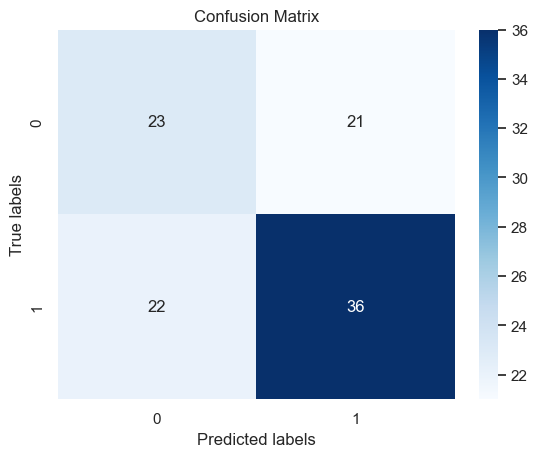

Con todas las características:
Promedio F1 en la validación cruzada: 0.6320904723203574
Mejores parámetros encontrados: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 7, 'n_estimators': 88}
F1-score promedio utilizando k-Fold Cross Validation: 0.6220912420912421


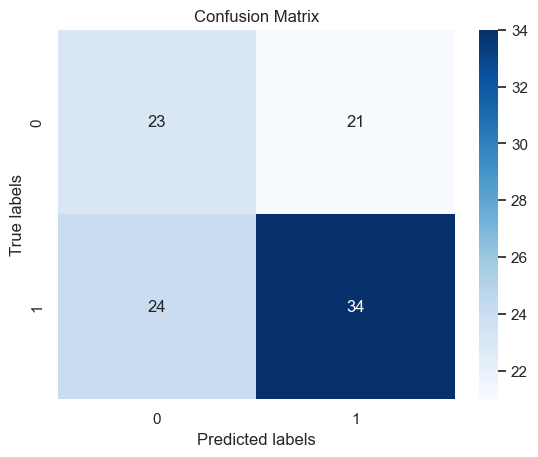

In [168]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score

# Seleccionar las características
selected_features = ['Marketing_expense', 'Budget', 'Movie_length', 'Time_taken','Avg_age_actors', 'Num_multiplex', 'Collection', '3D_available_YES','Genre_Comedy']
X_selected = df_new[selected_features]

# Partición del conjunto de datos en entrenamiento, validación y prueba
x_train, x_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=0) # Dividir en entrenamiento y validación

# Definir la cuadrícula de parámetros para la búsqueda aleatoria
param_grid = {
    'n_estimators': randint(50, 500),  # Número de árboles en el bosque
    'max_features': ['sqrt', 'log2', None],  # Opciones válidas para max_features
    'max_depth': randint(10, 100),  # Profundidad máxima del árbol
    'min_samples_split': randint(2, 10),  # Número mínimo de muestras requeridas para dividir un nodo interno
    'min_samples_leaf': randint(1, 10),  # Número mínimo de muestras requeridas en cada hoja del árbol
    'bootstrap': [True, False]  # Método de muestreo de datos
}

# Crear el clasificador Random Forest
rf_classifier = RandomForestClassifier()

# Realizar la búsqueda aleatoria
random_search = RandomizedSearchCV(rf_classifier, param_distributions=param_grid, n_iter=100, scoring='f1', n_jobs=-1, cv=5, random_state=0)

# Escalado de los datos
scaler = StandardScaler().fit(x_train)
X_train_scaled = scaler.transform(x_train)
X_val_scaled = scaler.transform(x_val)
X_test_scaled = scaler.transform(x_test)

# Realizar la validación cruzada en el conjunto de entrenamiento y validación
cv_scores = cross_val_score(random_search, np.vstack((X_train_scaled, X_val_scaled)), np.hstack((y_train, y_val)), scoring='f1', cv=5)

# Imprimir el promedio F1 en la validación cruzada
print("Con la selección de características:")
print("Promedio F1 en la validación cruzada:", np.mean(cv_scores))

# Entrenar el modelo con los mejores parámetros encontrados
best_rf_classifier = random_search.fit(np.vstack((X_train_scaled, X_val_scaled)), np.hstack((y_train, y_val)))

# Obtener los mejores parámetros encontrados
best_params = best_rf_classifier.best_params_
print("Mejores parámetros encontrados:", best_params)

# Predicciones en el conjunto de prueba
y_pred = best_rf_classifier.predict(X_test_scaled)

# Calcular F1-score utilizando k-Fold Cross Validation
f1_scores = cross_val_score(best_rf_classifier, X_test_scaled, y_test, scoring='f1', cv=10)
print("F1-score promedio utilizando k-Fold Cross Validation:", np.mean(f1_scores))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

##########################################################################################################################

# Seleccionar todas las características disponibles en el dataset
X_all_features = df_new.drop('Start_Tech_Oscar', axis=1)
y = df_new['Start_Tech_Oscar']

# Partición del conjunto de datos en entrenamiento, validación y prueba
x_train, x_test, y_train, y_test = train_test_split(X_all_features, y, test_size=0.2, random_state=0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=0) # Dividir en entrenamiento y validación

# Realizar la búsqueda aleatoria
random_search = RandomizedSearchCV(rf_classifier, param_distributions=param_grid, n_iter=100, scoring='f1', n_jobs=-1, cv=5, random_state=0)

# Escalado de los datos
scaler = StandardScaler().fit(x_train)
X_train_scaled = scaler.transform(x_train)
X_val_scaled = scaler.transform(x_val)
X_test_scaled = scaler.transform(x_test)

# Realizar la validación cruzada en el conjunto de entrenamiento y validación
cv_scores = cross_val_score(random_search, np.vstack((X_train_scaled, X_val_scaled)), np.hstack((y_train, y_val)), scoring='f1', cv=5)

# Imprimir el promedio F1 en la validación cruzada
print("Con todas las características:")
print("Promedio F1 en la validación cruzada:", np.mean(cv_scores))

# Entrenar el modelo con los mejores parámetros encontrados
best_rf_classifier = random_search.fit(np.vstack((X_train_scaled, X_val_scaled)), np.hstack((y_train, y_val)))

# Obtener los mejores parámetros encontrados
best_params = best_rf_classifier.best_params_
print("Mejores parámetros encontrados:", best_params)

# Predicciones en el conjunto de prueba
y_pred = best_rf_classifier.predict(X_test_scaled)

# Calcular F1-score utilizando k-Fold Cross Validation
f1_scores = cross_val_score(best_rf_classifier, X_test_scaled, y_test, scoring='f1', cv=10)
print("F1-score promedio utilizando k-Fold Cross Validation:", np.mean(f1_scores))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()